In [1]:
%matplotlib inline
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# from IPython.display import set_matplotlib_formats

# Plotting setup
# set_matplotlib_formats("pdf", "svg")
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts} \usepackage{amsmath}"


import torch
import torch.nn as nn
import torch.nn.functional as F

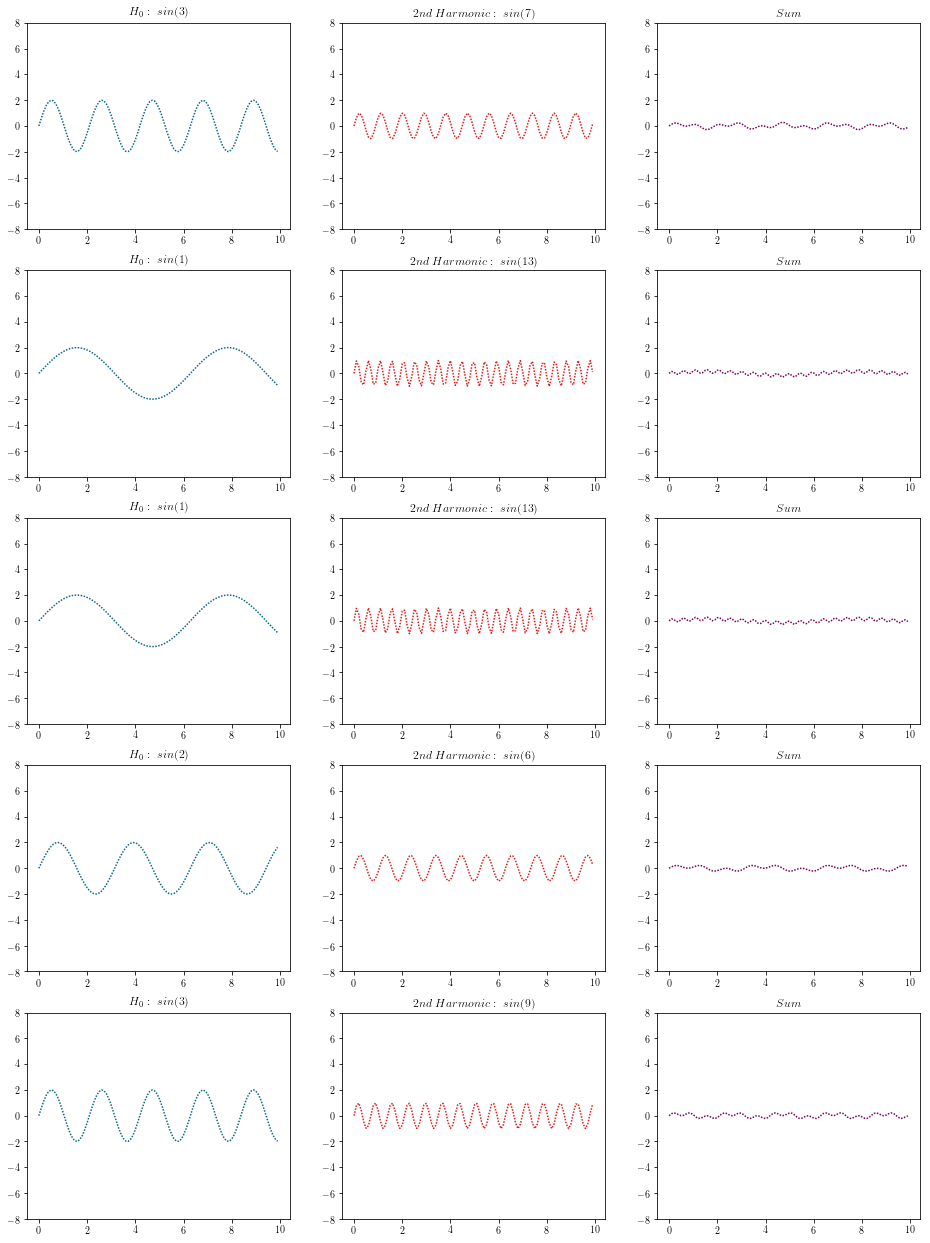

In [204]:

fig, axes = plt.subplots(nrows=5,ncols=3,figsize=(16,22))


x = np.arange(0,10, 0.1)


# generative process in real world
# a, b = 1, 10
# y = np.sin(a * x) + np.sin(b * x)



training_samples = []

# let's take some samples from 'the real world'
for a in range(5):
    w1, w2 = np.random.randint(1, 4), np.random.randint(5, 15)
    h0 = 2 * np.sin(w1*x)
    h1 = np.sin(w2 * x)
    y =  (h0/h0.std()) + (h1/h1.std())
    y /= 10#y.std()
#         y = w1 * np.sin(w2 * x)
#     for b in range(3):
#         r = np.random.randint(1, 10, size=2)
    training_samples.append(torch.unsqueeze(torch.unsqueeze(torch.Tensor(y), 0),0))


    axes[a][0].plot(x, h0,linestyle = (0, (1,1)), color = '#086788')
    axes[a][1].plot(x, h1,linestyle = (0, (1,1)), color = '#DD1C1A')
    axes[a][2].plot(x, y,linestyle = (0, (1,1)), color = '#770058')

    axes[a][0].set_title(f'$H_0:\;sin({w1})$')
    axes[a][1].set_title(f'$2nd\;Harmonic:\;sin({w2})$')
    axes[a][2].set_title(f'$Sum$')

# #         axes[a][b].set_title(f'Generating Factors: {np.mean(y):.4f}')

    axes[a][0].set_ylim(-8,8)
    axes[a][1].set_ylim(-8,8)
    axes[a][2].set_ylim(-8,8)



plt.show()













# so theroretically, we should be able to reconstruct it given, two latent variable only...
# Note, that we don't even need a decoder, we can just use sin(z_1) + sin(z_2) (thus reaching peak interpretability :D)

In [205]:
# Now, those are just some samples... Let's create an actual dataset
training_samples = []
for a in range(50):
    w1, w2 = np.random.randint(1, 4), np.random.randint(5, 15)
    h0 = 2 * np.sin(w1*x)
    h1 = np.sin(w2 * x)
    y =  h0 + h1
    y /= 10#         y = w1 * np.sin(w2 * x)
#     for b in range(3):
#         r = np.random.randint(1, 10, size=2)
    training_samples.append(torch.unsqueeze(torch.unsqueeze(torch.Tensor(y), 0),0))
    
print(f'We collected {len(training_samples)} samples')

We collected 50 samples


In [206]:
class FHVAE(nn.Module):
    def __init__(self):
        super(FHVAE, self).__init__()
        
        # encoder/inference
        
        # z2/sequence level
        self.lstm_z2 = nn.LSTM(100,4)
        self.mlp_mean_z2 = nn.Sequential(nn.Linear(4,4), nn.ReLU(), nn.Linear(4,4))
        self.mlp_std_z2 = nn.Sequential(nn.Linear(4,4), nn.ReLU(), nn.Linear(4,4))
        
        # z1/segment level
        self.lstm_z1 = nn.LSTM(4,4)
        self.mlp_mean_z1 = nn.Sequential(nn.Linear(4,4), nn.ReLU(), nn.Linear(4,4))
        self.mlp_std_z1 = nn.Sequential(nn.Linear(4,4), nn.ReLU(), nn.Linear(4,4))
        
        
        # decoder/generative
        self.mlp_mean_x = nn.Sequential(nn.Linear(4,50), nn.ReLU(), nn.Linear(50,100))
        self.mlp_std_x = nn.Sequential(nn.Linear(4,50), nn.ReLU(), nn.Linear(50,100))
        
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps= torch.empty(mu.size()).normal_(mean=0,std=1)#.unsqueeze(0) # works quite well
        
        return mu + eps*std
    
    
    def forward(self, x):
        # encode
        # z2
        _, (h_z2, c_z2) = self.lstm_z2(x)
        
        mu_z2 = self.mlp_mean_z2(h_z2)
        std_z2 = self.mlp_std_z2(h_z2)   
        
        z2 = self.reparameterize(mu_z2, std_z2)
        
        
        # z1
        _, (h_z1, c_z1) = self.lstm_z1(z2)
        
        mu_z1 = self.mlp_mean_z1(h_z1)
        std_z1 = self.mlp_std_z1(h_z1)   
        
        z1 = self.reparameterize(mu_z1, std_z1)
        
        
        # decode
        _, (h_x, c_x) = self.lstm_z1(z1)
        mu_x = self.mlp_mean_x(h_x)
        std_x = self.mlp_std_x(h_x)  
        
        x_hat = self.reparameterize(mu_x, std_x)

        
        
        return x_hat, (mu_z1,std_z1), (mu_z2,std_z2)
        
        

# model = FHVAE()

# # print(model)
# reconstruction, p_z1, p_z2 = model(training_samples[0])


# reconstruction

In [207]:
def loss_function(recon_x,
                  x,
                  mu_z1, logvar_z1,
                  mu_z2, logvar_z2,
                  tau=1):

    
    BCE = F.binary_cross_entropy(torch.sigmoid(recon_x), torch.sigmoid(x)) # reconstruction loss
    KLD_z1 = -0.5 * torch.sum(1 + logvar_z1 - mu_z1.pow(2) - logvar_z1.exp()) # KL-divergence from N(0,1)
    KLD_z2 = -0.5 * torch.sum(1 + logvar_z2 - mu_z2.pow(2) - logvar_z2.exp()) # KL-divergence from N(0,1)

    return BCE #+ 0.01 * (KLD_z1 + KLD_z2)# + tau * KLD

In [104]:
# print(F.binary_cross_entropy(torch.sigmoid(torch.Tensor([-1000])),torch.sigmoid(torch.Tensor([10])),reduction='sum'))

tensor(27.6298)


In [208]:
def train_single_epoch(model, optimizer, data):
    model.train()
    train_loss = 0
    i = 0
    for x in data:
        i += 1
        reconstruction, p_z1, p_z2  = model(x)
#         loss = criterion(reconstruction, x)
        loss = loss_function(reconstruction, x, p_z1[0], p_z1[1], p_z2[0], p_z2[1])

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / i  # /dataloader.size() #->normalize


# optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # 0.001


# train_single_epoch(model, optimizer, training_samples)


Epoch: 0, Loss: 0.74
Epoch: 20, Loss: 0.72
Epoch: 40, Loss: 0.75
Epoch: 60, Loss: 0.77
Epoch: 80, Loss: 0.77
Epoch: 100, Loss: 0.78
Epoch: 120, Loss: 0.79
Epoch: 140, Loss: 0.81
Epoch: 160, Loss: 0.82
Epoch: 180, Loss: 0.81
Epoch: 200, Loss: 0.83
Epoch: 220, Loss: 0.83
Epoch: 240, Loss: 0.84
Epoch: 260, Loss: 0.83
Epoch: 280, Loss: 0.85


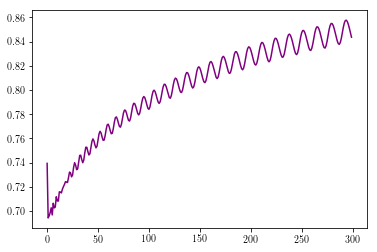

In [209]:
model = FHVAE()

optimizer = torch.optim.Adam(model.parameters(), lr=0.005) # 0.001


# train_single_epoch(model, optimizer, training_samples)


losses = []
num_epochs = 300
for epoch in range(num_epochs):
    loss = train_single_epoch(model, optimizer, training_samples)
    losses.append(loss)
    if epoch%20==0:
        print('Epoch: {}, Loss: {:.2f}'.format(epoch, loss))
# torch.save(model.state_dict(), 'model_credit_score_1000.pth')
plt.plot(losses, color='purple')
plt.show()

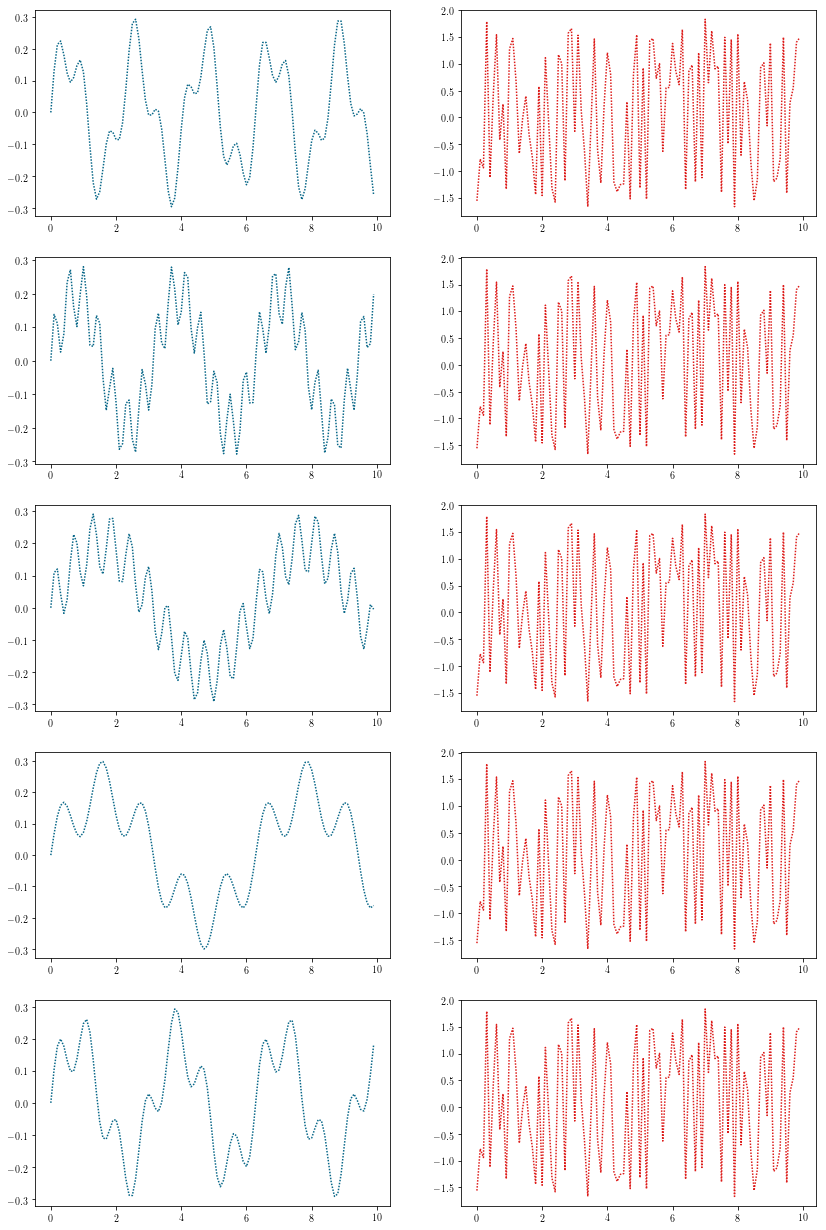

In [210]:

fig, axes = plt.subplots(nrows=5,ncols=2,figsize=(14,22))

# x = np.arange(0,10, 0.1)


# training_samples = []


# let's take some samples from 'the real world'

for a in range(5):
#     for b in range(3)
    y = training_samples[a].numpy()[0][0]
    y_reconstructed, _, _ = model(training_samples[a])
    y_reconstructed = y_reconstructed.detach().numpy()[0][0]
#         y = w1 * np.sin(w2 * x)
#     for b in range(3):
#         r = np.random.randint(1, 10, size=2)
#     training_samples.append(torch.unsqueeze(torch.unsqueeze(torch.Tensor(y), 0),0))
#     print(y.shape)


    axes[a][0].plot(x, y,linestyle = (0, (1,1)), color = '#086788')
    axes[a][1].plot(x, y_reconstructed,linestyle = (0, (1,1)), color = '#DD1C1A')
#     axes[a][2].plot(x, y,linestyle = (0, (1,1)), color = '#770058')

#     axes[a][0].set_title(f'$H_0:\;sin({w1})$')
#     axes[a][1].set_title(f'$2nd\;Harmonic:\;sin({w2})$')
#     axes[a][2].set_title(f'$Sum$')

# # #         axes[a][b].set_title(f'Generating Factors: {np.mean(y):.4f}')

#     axes[a][0].set_ylim(-8,8)
#     axes[a][1].set_ylim(-8,8)
#     axes[a][2].set_ylim(-8,8)



plt.show()
